# Notebook 3: Introduction to coordinate reference systems (CRS)

In this notebook we will learn the basics of working with CRSs with Python. For our land use analysis, we have datasets with different CRSs. We need to choose one CRS and make sure all of our data is projected to that CRS.


## Get the CRS for raster and vector data

While the details may vary depending on the data structure used to store your raster or vector data, there should be a way to extract the CRS information. We'll do this for `DataArray` and `GeoDataFrame` objects.

In [1]:
# Load libraries
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import rioxarray
import geopandas as gpd


Use rioxarray's [open_rasterio()](https://corteva.github.io/rioxarray/html/rioxarray.html) method to read the TIFF file into an xarray `DataArray`. 

In [4]:
ou_landcover_2021_da = rioxarray.open_rasterio(Path('../data', 'ou_land_cover_2021.tif'))
ou_landcover_2021_da

<xarray.DataArray (band: 1, y: 166, x: 375)> Size: 62kB
[62250 values with dtype=uint8]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 3kB 1.034e+06 1.034e+06 ... 1.045e+06 1.045e+06
  * y            (y) float64 1kB 2.258e+06 2.258e+06 ... 2.253e+06 2.253e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:        Area
    LAYER_TYPE:           thematic
    OVERVIEWS_ALGORITHM:  IMAGINE Nearest Neighbor Resampling
    scale_factor:         1.0
    add_offset:           0.0
    long_name:            Layer_1

We will use the same vector file containing place boundaries that we used in the last notebook. After reading in the place file for the state of Michigan, we'll query it to extract the boundaries for Auburn Hills and Rochester Hills.

In [5]:
mi_places_file = Path('../data', 'cb_2022_26_place_500k', 'cb_2022_26_place_500k.shp')
mi_places_gdf = gpd.read_file(mi_places_file)

ou_places_gdf = mi_places_gdf.query('NAME == "Auburn Hills" or NAME == "Rochester Hills"')
ou_places_gdf

,STATEFP,PLACEFP,PLACENS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry
471,26,04105,01625860,1600000US2604105,2604105,Auburn Hills,Auburn Hills city,MI,Michigan,25,43095047,113296,"POLYGON ((-83.32895 42.70592, -83.30717 42.707..."
731,26,69035,01626990,1600000US2669035,2669035,Rochester Hills,Rochester Hills city,MI,Michigan,25,84960992,254848,"POLYGON ((-83.21403 42.70952, -83.19542 42.709..."


Using the open source GIS package, [QGIS](), I manually created a vector layer containing a polygon corresponding to the OU campus. I exported the layer to a [GeoJSON]() file which is another common file format for storing vector data. Here's what the exported file looks like:

```
{
"type": "FeatureCollection",
"name": "ou_boundary",
"crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
"features": [
{ "type": "Feature", "properties": { "fid": 1 }, "geometry": { "type": "Polygon", "coordinates": [ [ [ -83.220509168388844, 42.678653446491893 ], [ -83.214464053848729, 42.678723363504986 ], [ -83.210359202794379, 42.679828386721063 ], [ -83.194121952514863, 42.68031233903384 ], [ -83.193293099256138, 42.660199281509463 ], [ -83.19932851264484, 42.660173960983528 ], [ -83.219499255162631, 42.653238421627883 ], [ -83.216759168858616, 42.659141411113964 ], [ -83.217451868747403, 42.662629547726418 ], [ -83.218857978317274, 42.664900089508016 ], [ -83.21972258817641, 42.666806311613314 ], [ -83.220509168388844, 42.678653446491893 ] ] ] } }
]
}

```

It's essentially a dictionary (it is JSON, after all) with a `features` key that contains a list of dictionaries. Each of these dictionaries corresponds to one feature and has keys that include `geometry` which contains the actual data defining, in this case, our polygon. Just as with the shapefile, we can load this data into a `GeoDataFrame`. GeoPandas uses the file extension to infer the incoming data structure.

In [6]:
ou_boundary_file = Path('../data', 'ou_boundary.geojson')
ou_boundary_gdf = gpd.read_file(ou_boundary_file)

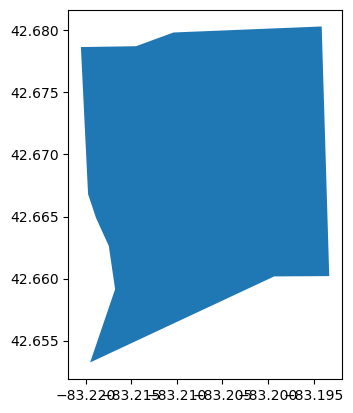

In [7]:
ou_boundary_gdf.plot();

In [8]:
ou_boundary_gdf.total_bounds

array([-83.22050917,  42.65323842, -83.1932931 ,  42.68031234])

So, we have three different datasets:

- a raster containing land use classification values
- a vector containing the boundaries of Auburn Hills and Rochester Hills
- a vector containing the boundaries of Oakland University (manually created in QGIS).

In order to plot all three on the same map, we need to make sure we use a common CRS. First, let's confirm which CRS is being used for each.

For raster data stored in an xarray `DataArray`, we use the rioxarray `rio` accessor to get the `crs` property. The `rio` accessor is how you use the geospatial functionality that **rioxarray** adds to **xarray**.

In [9]:
print(ou_landcover_2021_da.rio.crs)

PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


The representation above is known as WKT, or [Well Known Text](https://en.wikipedia.org/wiki/Well-known_text_representation_of_coordinate_reference_systems). It is meant to be human readable as well as machine readable.

From the above, we can determine that the [Albers Conical Equal Area](https://en.wikipedia.org/wiki/Albers_projection) projected CRS is being used for this raster data. This CRS is commonly used for North America and is one of the [projections used by the USGS](https://www.usgs.gov/publications/map-projections-used-us-geological-survey).

For the `GeoDataFrame` objects containing vector data, we can just use the `crs` property directly.

In [10]:
print(f'ou_places_gdf CRS: {ou_places_gdf.crs}')

ou_places_gdf CRS: EPSG:4269


In [11]:
print(f'ou_boundary_gdf CRS: {ou_boundary_gdf.crs}')

ou_boundary_gdf CRS: EPSG:4326


Both of these CRSs seem to use longitude and latitude for their X and Y coordinate values. We know this is the case for EPSG:4326. What exactly is EPSG:4269? Googling "EPSG:4326 vs EPSG:4269" leads to this informative post on GIS StackExchange:

- [https://gis.stackexchange.com/questions/170839/is-re-projection-needed-from-srid-4326-wgs-84-to-srid-4269-nad-83](https://gis.stackexchange.com/questions/170839/is-re-projection-needed-from-srid-4326-wgs-84-to-srid-4269-nad-83)

While both projections use long/lat, they use different underlying datums (ellipsoid models of the earth). Regardless, we want to use the Albers Conical Equal Area projection for our plot as it is a projected CRS, whereas EPSG:4326 is not.

How do we do this? Many geospatial analysis packages have reprojection capabilities - usually they are leveraging GDAL and PROJ. However, a few things to keep in mind:

- reprojecting large raster files is computationally demanding. I've had problems doing such reprojections with Python packages and have had to resort to the GDAL command line utilities (which are awesome).
- it can be tricky to correctly specify the textual code for a given CRS (more on this below).

### Using GeoPandas to reproject vector data

GeoPandas has a `to_crs` method that can reproject the `GeoDataFrame` to any projection we wish. 

In [12]:
help(ou_places_gdf.to_crs)

Help on method to_crs in module geopandas.geodataframe:

to_crs(crs=None, epsg=None, inplace=False) method of geopandas.geodataframe.GeoDataFrame instance
    Transform geometries to a new coordinate reference system.
    
    Transform all geometries in an active geometry column to a different coordinate
    reference system.  The ``crs`` attribute on the current GeoSeries must
    be set.  Either ``crs`` or ``epsg`` may be specified for output.
    
    This method will transform all points in all objects. It has no notion
    of projecting entire geometries.  All segments joining points are
    assumed to be lines in the current projection, not geodesics. Objects
    crossing the dateline (or other projection boundary) will have
    undesirable behavior.
    
    Parameters
    ----------
    crs : pyproj.CRS, optional if `epsg` is specified
        The value can be anything accepted by
        :meth:`pyproj.CRS.from_user_input() <pyproj.crs.CRS.from_user_input>`,
        such as an

The first two arguments, `crs` and `epsg`, give us a few ways to specify the destination CRS. If you look closely at the `crs` argument, it expects a `pyproj.CRS` object or a valid text representation of the CRS such as "EPSG:4326" or a WKT string. Actually, there are a [whole lot of ways to specify the destination CRS](https://geopandas.org/en/stable/docs/user_guide/projections.html).

What is `pyproj`?

The [pyproj library](https://pyproj4.github.io/pyproj/stable/) is a:

> Python interface to PROJ (cartographic projections and coordinate transformations library).

According to the docs, `pyproj.crs.CRS` provides a "Pythonic Coordinate Reference System manager".

In [13]:
crs_land_use_raster = ou_landcover_2021_da.rio.crs
print(type(crs_land_use_raster))

<class 'rasterio.crs.CRS'>


Now we can use this existing `CRS` object to specify the destination CRS for our vector data.

In [14]:
ou_places_aea_gdf = ou_places_gdf.to_crs(crs_land_use_raster)
ou_boundary_aea_gdf = ou_boundary_gdf.to_crs(crs_land_use_raster)

### Question

Check the CRS of the two vector dataframes.

In [ ]:
# CRS of the vector dataframes


### Answer

In [ ]:
print(ou_places_aea_gdf.crs)
print(ou_boundary_aea_gdf.crs)

## Plotting the data

Let's plot these the two vector dataframes. They should overlap.

GeoPandas has a built in `plot()` function that operates on `GeoDataFrames. See [https://geopandas.org/en/stable/docs/user_guide/mapping.html](https://geopandas.org/en/stable/docs/user_guide/mapping.html) for all the details. Most of the options are standard matplotlib things for controlling details of the plot appearance.

### Challenge: Plot the two vector `GeoDataFrames`

In [ ]:
# Plot vector dataframes


### Answer

<Axes: >

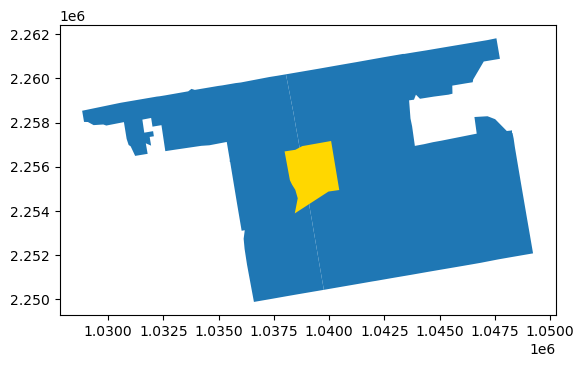

In [22]:
fig, ax = plt.subplots()
ou_places_aea_gdf.plot(ax=ax)
ou_boundary_aea_gdf.plot(ax=ax, color='gold')

The plot reveals something interesting. The OU campus straddles the border between Auburn Hills and Rochester Hills. 

### Combining raster and vector data in a plot

Let's try adding the land use raster to our plot. Remember, this raster contains a bunch of area surrounding the OU campus, but doesn't contain all of Auburn Hills and Rochester Hills.

A few things to note in the code below:

- use the `alpha` parameter to control transparency of the different levels,
- use the `zorder` parameter to control how the layers stacked (`zorder=1` is the bottom layer).

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

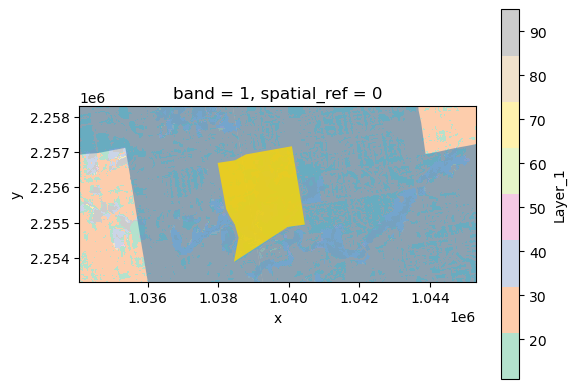

In [18]:
fig, ax = plt.subplots()
ou_landcover_2021_da.plot(ax=ax, cmap='Pastel2', zorder=1)
ou_places_aea_gdf.plot(ax=ax, alpha=0.5, zorder=2)
ou_boundary_aea_gdf.plot(ax=ax, color='gold', alpha=0.8, zorder=3)


Seems like the default extent is being controlled by the size of the raster. Another option for geospatial plotting in Python is the [Cartopy](http://scitools.org.uk/cartopy/docs/latest/) package.

From the [Cartopy docs](https://scitools.org.uk/cartopy/docs/latest/):

> - Cartopy is a Python package designed for geospatial data processing in order to produce maps and other geospatial data analyses.
>
> - Cartopy makes use of the powerful PROJ, NumPy and Shapely libraries and includes a programmatic interface built on top of Matplotlib for the creation of publication quality maps.
>
> - Key features of cartopy are its object oriented projection definitions, and its ability to transform points, lines, vectors, polygons and images between those projections.
>
> - You will find cartopy especially useful for large area / small scale data, where Cartesian assumptions of spherical data traditionally break down. If you’ve ever experienced a singularity at the pole or a cut-off at the dateline, it is likely you will appreciate cartopy’s unique features!

We won't go into much detail with Cartopy right now.

In [15]:
import cartopy.crs as ccrs                   # import projections

We'll create a CRS object for our Albers projections. This will get used when we create the plot axes.

In [16]:
crs_aea = ccrs.AlbersEqualArea()

Cartopy makes it easy to set the map extent using a bounding box. However, it wants the elements of the box in a slightly different order than what we've used previously. Cartopy specifies extents with **(xmin, xmax, ymin, ymax)**. We can use the `ou_places_aea_gdf` dataframe as the basis for our extent,

In [17]:
# Notice xmin, ymin, xmax, ymax
ou_places_aea_gdf.total_bounds

array([1028821.72370821, 2249882.28354187, 1049224.58562468,
       2261812.53566168])

In [18]:
# Notice xmin, xmax, ymin, ymax
ou_places_extent = (ou_places_aea_gdf.total_bounds[0], 
                    ou_places_aea_gdf.total_bounds[2], 
                    ou_places_aea_gdf.total_bounds[1], 
                    ou_places_aea_gdf.total_bounds[3])

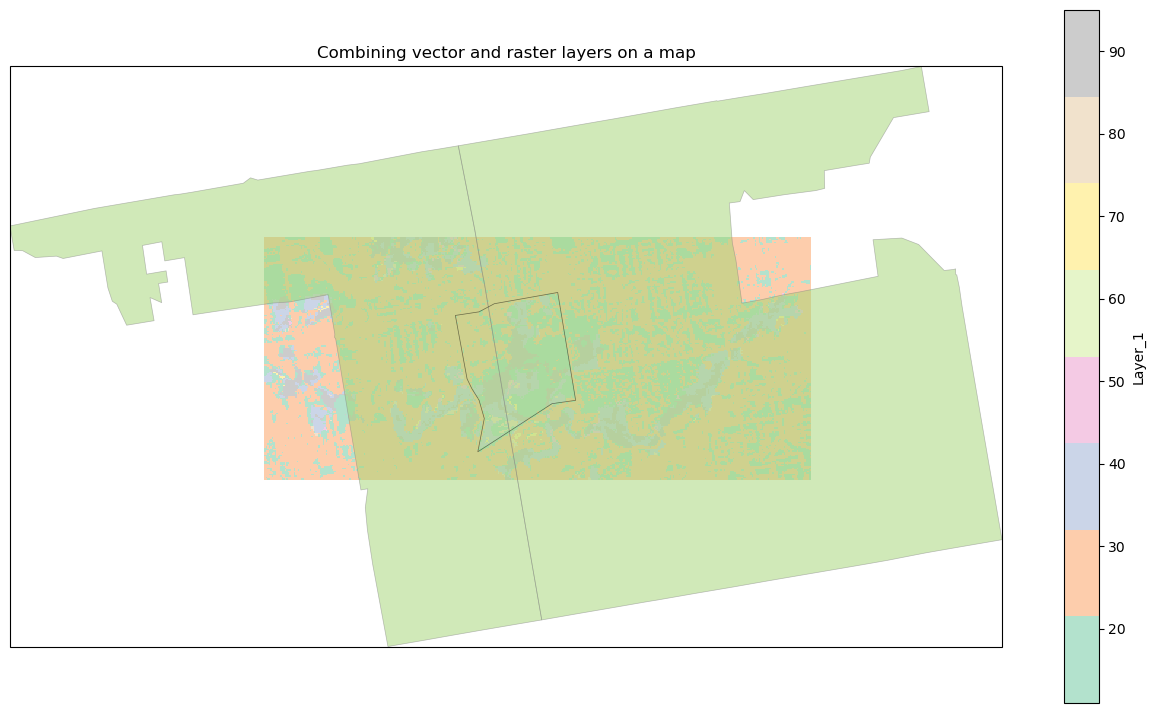

In [19]:
# Create figure and set size
fig1 = plt.figure()
fig1.set_figheight(9)
fig1.set_figwidth(16)

# create a set of axes with desired projection  
ax1 = plt.axes(projection = crs_aea)

# Set map extent
ax1.set_extent(ou_places_extent, crs = crs_aea)

# Add vectors
ax1.add_geometries(ou_places_aea_gdf.geometry, crs=crs_aea, 
                   facecolor="#a2d572", edgecolor="grey", linewidth=0.5, alpha=0.5) 
ax1.add_geometries(ou_boundary_aea_gdf.geometry, facecolor="none", crs=crs_aea, edgecolor="black", linewidth=0.5, alpha=0.5) 

# Add land use raster
ou_landcover_2021_da.plot(ax=ax1, cmap='Pastel2')

ax1.set_title("Combining vector and raster layers on a map")                    
plt.show()

The reprojections seem to have worked as we can see the raster and both vector layers on our plot. Obviously, more work is needed to make this usable. In later sections we'll learn how to clip data layers to just include the data we want to plot as well to fine tune our maps.